In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2024-07-06 10:20:16.818967: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 10:20:16.833246: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 10:20:16.981130: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 10:20:17.213866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 10:20:17.436570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

# Base

In [62]:
df_ratings = pd.read_csv('corporateCreditRatingWithFinancialRatios.csv')

In [63]:
input_columns = ['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
                 'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
                 'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
                 'ROE - Return On Equity', 'Return On Tangible Equity',
                 'ROA - Return On Assets', 'ROI - Return On Investment',
                 'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

# *Encoding*

A partir daqui, há uma diferenciação entre dois modelos testados, um com um neurônio na camada de saída (*label encoding*) e um com um neurônio por *rating* (*one hot encoding*).

In [64]:
# label_encoder_dict = {
#     "AAA": (round(0/25, 2), round(25/25, 2)),
#     "AA+": (round(1/25, 2), round(24/25, 2)),
#     "AA": (round(2/25, 2), round(23/25, 2)),
#     "AA-": (round(3/25, 2), round(22/25, 2)),
#     "A+": (round(4/25, 2), round(21/25, 2)),
#     "A": (round(5/25, 2), round(20/25, 2)),
#     "A-": (round(6/25, 2), round(19/25, 2)),
#     "BBB+": (round(7/25, 2), round(18/25, 2)),
#     "BBB": (round(8/25, 2), round(17/25, 2)),
#     "BBB-": (round(9/25, 2), round(16/25, 2)),
#     "BB+": (round(10/25, 2), round(15/25, 2)),
#     "BB": (round(11/25, 2), round(14/25, 2)),
#     "BB-": (round(12/25, 2), round(13/25, 2)),
#     "B+": (round(13/25, 2), round(12/25, 2)),
#     "B": (round(14/25, 2), round(11/25, 2)),
#     "B-": (round(15/25, 2), round(10/25, 2)),
#     "CCC+": (round(16/25, 2), round(9/25, 2)),
#     "CCC": (round(17/25, 2), round(8/25, 2)),
#     "CCC-": (round(18/25, 2), round(7/25, 2)),
#     "CC+": (round(19/25, 2), round(6/25, 2)),
#     "CC": (round(20/25, 2), round(5/25, 2)),
#     "CC-": (round(21/25, 2), round(4/25, 2)),
#     "C+": (round(22/25, 2), round(3/25, 2)),
#     "C": (round(23/25, 2), round(2/25, 2)),
#     "C-": (round(24/25, 2), round(1/25, 2)),
#     "D": (round(25/25, 2), round(0/25, 2))
# }

label_encoder_dict = {
    "AAA": (round(0/9, 2), round(9/9, 2)),
    "AA": (round(1/9, 2), round(8/9, 2)),
    "A": (round(2/9, 2), round(7/9, 2)),
    "BBB": (round(3/9, 2), round(6/9, 2)),
    "BB": (round(4/9, 2), round(5/9, 2)),
    "B": (round(5/9, 2), round(4/9, 2)),
    "CCC": (round(6/9, 2), round(3/9, 2)),
    "CC": (round(7/9, 2), round(2/9, 2)),
    "C": (round(8/9, 2), round(1/9, 2)),
    "D": (round(9/9, 2), round(0/9, 2))
}

encoder_descending = 1

label_decoder_dict = {}
for k in label_encoder_dict.keys():
    label_decoder_dict[label_encoder_dict[k][encoder_descending]] = k

In [65]:
df_ratings["Rating"] = df_ratings["Rating"].str.replace("+", "").str.replace("-", "")
df_ratings["Rating Encoded"] = df_ratings["Rating"].apply(lambda x: label_encoder_dict[x.strip()][encoder_descending])

In [66]:
encoder = OneHotEncoder(sparse=False)

# Remoção de *outliers* baseado em estudo prévio

In [80]:
ranges = {
    "Current Ratio": (-5, 20),
    "Long-term Debt / Capital": (-7, 15),
    "Debt/Equity Ratio": (-200, 250),
    "Gross Margin": (-25, 150),
    "Operating Margin": (-250, 100),
    "EBIT Margin": (-200, 100),
    "EBITDA Margin": (-200, 100),
    "Pre-Tax Profit Margin": (-100, 150),
    "Net Profit Margin": (-150, 150),
    "Asset Turnover": (-10, 6),
    "ROE - Return On Equity": (-2500, 2500),
    "Return On Tangible Equity": (-2500, 2500),
    "ROA - Return On Assets": (-100, 80),
    "ROI - Return On Investment": (-250, 250),
    "Operating Cash Flow Per Share": (-80, 100),
    "Free Cash Flow Per Share": (-50, 50)
}

for column in input_columns:
    df_ratings.drop(df_ratings[(df_ratings[column] < ranges[column][0]) | (df_ratings[column] > ranges[column][1])].index, inplace=True)

In [81]:
len(df_ratings)

7620

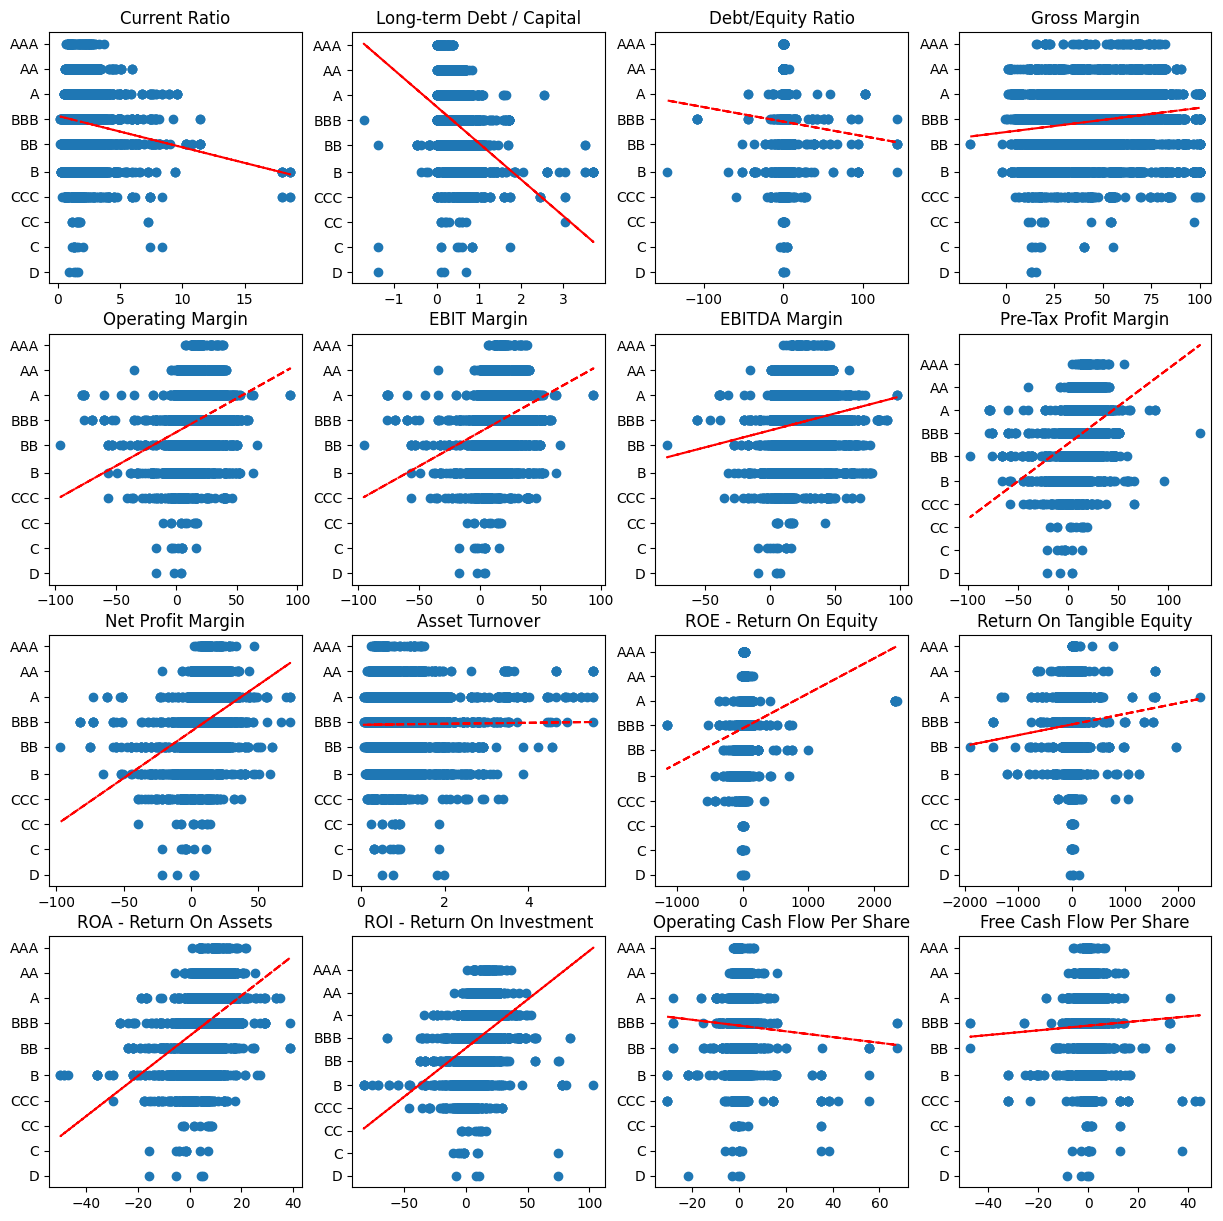

In [82]:
def subplot(ax, col):
    ax.scatter(df_ratings[[col]], df_ratings[['Rating Encoded']])
    coef = np.polyfit(df_ratings[col], df_ratings['Rating Encoded'], 1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(df_ratings[col], poly1d_fn(df_ratings[col]), '--r')
    ax.set_title(col)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

k = 0

for i in range(4):
    for j in range(4):

        ax = plt.subplot2grid((4, 4), (i, j))
        # ticks_list = [1.0, 0.8, 0.6, 0.4, 0.2, 0]
        ticks_list = list(label_decoder_dict.keys())
        ax.set_yticks(ticks_list)
        ax.set_yticklabels([label_decoder_dict.get(i) for i in ticks_list])

        col = input_columns[k]
        subplot(ax, col)
        k += 1

plt.show()

In [83]:
df_relevant = df_ratings[input_columns + ['Rating Encoded']]
correlation_matrix = df_relevant.corr()

# Obter a correlação com a coluna de rating numérico
rating_correlation = correlation_matrix['Rating Encoded'].drop('Rating Encoded')

# Exibir os resultados
print("Correlação entre cada métrica financeira e o rating:")
# print(rating_correlation.sort_values())
df_rating_correlation = rating_correlation.to_frame()
df_rating_correlation['abs(Rating)'] = abs(df_rating_correlation['Rating Encoded'])
df_rating_correlation.sort_values('abs(Rating)', ascending=False).drop(columns=['abs(Rating)'])

Correlação entre cada métrica financeira e o rating:


,Rating Encoded
ROA - Return On Assets,0.365555
Pre-Tax Profit Margin,0.343765
ROI - Return On Investment,0.338904
Long-term Debt / Capital,-0.335494
Net Profit Margin,0.326790
EBIT Margin,0.269381
Operating Margin,0.268316
Gross Margin,0.174700
EBITDA Margin,0.162445
Current Ratio,-0.138635


# Normalização

In [11]:
df_ratings[input_columns].describe()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,1.860072,0.448264,1.243693,42.528869,13.431385,13.473663,21.661461,10.578210,7.630217,0.848339,12.797606,11.557842,5.084275,8.150452,0.497883,0.156829
std,1.444870,0.297426,8.067156,23.457306,12.912596,12.938893,15.579345,13.642148,11.451457,0.679104,57.570496,149.648694,5.918733,10.220414,3.834181,3.469286
min,0.205400,-1.722800,-146.450000,-18.203900,-95.629500,-95.629500,-78.951000,-97.331300,-97.057100,0.068400,-1149.999000,-1900.000000,-49.752600,-82.448400,-30.758700,-47.240300
25%,1.077100,0.285500,0.425500,22.625400,6.389200,6.441100,11.253500,4.195100,2.882500,0.403000,6.228400,-11.052300,2.472300,3.932400,-0.419300,-0.707600
50%,1.497200,0.424800,0.752800,39.648400,12.369600,12.386200,18.530300,9.796000,7.056300,0.666700,12.519900,10.804100,4.849500,7.512800,0.239700,0.135200
75%,2.154000,0.534200,1.208800,59.574500,19.570500,19.620700,31.052700,16.878300,12.440800,1.038800,20.364700,26.894100,7.923400,12.552200,1.079700,0.982000
max,18.665100,3.712900,143.061600,100.000000,93.993000,93.993000,97.186600,131.386900,73.607800,5.553000,992.973100,2410.121000,38.823000,103.315200,67.406100,44.922600


In [12]:
df_train = df_ratings[input_columns].copy().reset_index(drop=True)
# df_train.iloc[:, 0:-1] = StandardScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())
df_train.iloc[:, 0:-1] = MinMaxScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())

In [13]:
df_train.describe()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,0.089637,0.399408,0.510148,0.513797,0.575147,0.575370,0.571215,0.471801,0.613409,0.142205,0.542609,0.443504,0.619097,0.487710,0.318409,0.156829
std,0.078272,0.054717,0.027865,0.198448,0.068096,0.068235,0.088450,0.059646,0.067099,0.123820,0.026865,0.034720,0.066821,0.055018,0.039059,3.469286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-47.240300
25%,0.047222,0.369465,0.507322,0.345414,0.538009,0.538283,0.512125,0.443893,0.585590,0.061007,0.539544,0.438259,0.589608,0.465004,0.309066,-0.707600
50%,0.069979,0.395092,0.508452,0.489428,0.569548,0.569635,0.553438,0.468381,0.610046,0.109087,0.542480,0.443330,0.616446,0.484278,0.315779,0.135200
75%,0.105560,0.415218,0.510027,0.658002,0.607523,0.607788,0.624533,0.499346,0.641596,0.176932,0.546140,0.447063,0.651150,0.511406,0.324336,0.982000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,44.922600


# Amostras de treino e de teste

In [14]:
X = df_train[input_columns]

y = df_ratings['Rating Encoded']
y_one_hot = encoder.fit_transform(df_ratings[['Rating']])

/home/cmore/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Treinamento

In [16]:
# Uma saída

model_1 = Sequential([
    Dense(64, activation='relu', input_dim=len(X_train.columns)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0067 - loss: 0.6879 - val_accuracy: 0.0190 - val_loss: 0.6393
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0113 - loss: 0.6390 - val_accuracy: 0.0190 - val_loss: 0.6381
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0081 - loss: 0.6403 - val_accuracy: 0.0190 - val_loss: 0.6377
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0103 - loss: 0.6398 - val_accuracy: 0.0190 - val_loss: 0.6374
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0114 - loss: 0.6387 - val_accuracy: 0.0190 - val_loss: 0.6372
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0100 - loss: 0.6392 - val_accuracy: 0.0190 - val_loss: 0.6370
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0080 - loss: 0.6402 - val_accuracy: 0.0190 - val_loss: 0.6369
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0119 - loss: 0.6412 - val_accu

In [17]:
# Uma saída por rating

model_many = Sequential([
    Dense(256, activation='relu', input_dim=len(X_train_one_hot.columns)),
    Dense(128, activation='relu'),
    Dense(y_one_hot.shape[1], activation='softmax')
])

model_many.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_many.fit(X_train_one_hot, y_train_one_hot, epochs=300, batch_size=32, validation_data=(X_test_one_hot, y_test_one_hot))

Epoch 1/300


/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3053 - loss: 1.7753 - val_accuracy: 0.3106 - val_loss: 1.6440
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3417 - loss: 1.6025 - val_accuracy: 0.3454 - val_loss: 1.6036
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3626 - loss: 1.5658 - val_accuracy: 0.3342 - val_loss: 1.5632
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3629 - loss: 1.5352 - val_accuracy: 0.3907 - val_loss: 1.5126
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3775 - loss: 1.4877 - val_accuracy: 0.3487 - val_loss: 1.5196
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3982 - loss: 1.4697 - val_accuracy: 0.4012 - val_loss: 1.4882
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4035 - loss: 1.4574 - val_accuracy: 0.3913 - val_loss: 1.4484
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4058 - loss: 1.4320 - val_accuracy: 0.4196

# Transformando saídas na classificação desejada

In [20]:
def result(x):
    for i in label_decoder_dict.keys():
        # if abs(x - i) <= 0.02:
        if abs(x - i) <= 0.11:
            return i
    return None

In [21]:
y_pred_1 = model_1.predict(X_test)
y_pred_1 = [result(yp) for yp in y_pred_1]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [22]:
y_pred_many = model_many.predict(X_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
y_pred_many.argmax(axis=1).reshape(-1, 1)

array([[5],
       [1],
       [0],
       ...,
       [0],
       [0],
       [4]])

In [24]:
y_pred_many = y_pred_many.argmax(axis=1).reshape(-1, 1)
y_pred_many_rating = np.zeros((y_pred_many.size, y_one_hot.shape[1]))
y_pred_many_rating[np.arange(y_pred_many.size).reshape(-1, 1), y_pred_many] = 1
y_pred_many_rating

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
y_pred_many_rating = encoder.inverse_transform(y_pred_many_rating)
y_pred_many_rating

array([['BBB'],
       ['AA'],
       ['A'],
       ...,
       ['A'],
       ['A'],
       ['BB']], dtype=object)

# Análise dos resultados

- Resultado igual ao esperado:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AA $^+$   |

- Resultado igual ao esperado, desonsiderando *high* e *low*:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AA $^-$   |

- Mesma letra:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AAA       |

In [26]:
df_pred = pd.DataFrame({"Pred 1": y_pred_1, "Test": y_test}).reset_index(drop=True)

In [27]:
df_pred['Pred 1 Rating'] = df_pred['Pred 1'].apply(lambda x: label_decoder_dict[x])
df_pred['Pred Many Rating'] = y_pred_many_rating.reshape(1, -1).tolist()[0]
df_pred['Test Rating'] = df_pred['Test'].apply(lambda x: label_decoder_dict[x])

In [28]:
df_pred["1: Igual sem high/low"] = (df_pred['Pred 1 Rating'].str.replace("+", "").str.replace("-", "") ==
                                 df_pred['Test Rating'].str.replace("+", "").str.replace("-", ""))

df_pred["1: Mesma letra"] = df_pred['Pred 1 Rating'].str[0] == df_pred['Test Rating'].str[0]

df_pred["Many: Igual sem high/low"] = (df_pred['Pred Many Rating'].str.replace("+", "").str.replace("-", "") ==
                                       df_pred['Test Rating'].str.replace("+", "").str.replace("-", ""))

df_pred["Many: Mesma letra"] = df_pred['Pred Many Rating'].str[0] == df_pred['Test Rating'].str[0]

In [29]:
print("1 neurônio na camada de saída:")
print(f'Igual: {len(df_pred[df_pred["Pred 1 Rating"] == df_pred["Test Rating"]])/len(df_pred)}')
print(f'Igual sem high/low: {len(df_pred[df_pred["1: Igual sem high/low"]])/len(df_pred)}')
print(f'Mesma letra: {len(df_pred[df_pred["1: Mesma letra"]])/len(df_pred)}')

print("Um neurônio por rating na camada de saída:")
print(f'Igual: {len(df_pred[df_pred["Pred Many Rating"] == df_pred["Test Rating"]])/len(df_pred)}')
print(f'Igual sem high/low: {len(df_pred[df_pred["Many: Igual sem high/low"]])/len(df_pred)}')
print(f'Mesma letra: {len(df_pred[df_pred["Many: Mesma letra"]])/len(df_pred)}')

1 neurônio na camada de saída:
Igual: 0.3598161523309258
Igual sem high/low: 0.3598161523309258
Mesma letra: 0.6815495732107683
Um neurônio por rating na camada de saída:
Igual: 0.556795797767564
Igual sem high/low: 0.556795797767564
Mesma letra: 0.783322390019698
